In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel("barnstable_analysis_data.xlsx", sheet_name='data')
df

,date,SPX,TB1M
0,1926-01-30,-0.001783,0.003061
1,1926-02-27,-0.033297,0.002612
2,1926-03-31,-0.057708,0.002601
3,1926-04-30,0.038522,0.002270
4,1926-05-28,0.013623,0.002691
...,...,...,...
1183,2024-08-30,0.024283,0.004380
1184,2024-09-30,0.022821,0.003826
1185,2024-10-31,-0.008690,0.003752
1186,2024-11-29,0.060420,0.003475


### 1 Summary Statistics

In [3]:
ret = pd.DataFrame({
    'date': df['date'],
    'r_mkt': df['SPX'],
    'r_ex': df['SPX'] - df['TB1M'],
    'r_f': df['TB1M'],
    'log_r_mkt': np.log(1 + df['SPX']),
    'log_r_ex': np.log(1 + df['SPX'] - df['TB1M']),
    'log_r_f': np.log(1 + df['TB1M'])
})

ret['date'] = pd.to_datetime(ret['date'])
periods = [(1965, 1999), (2000, 2024), (1926, 2024)]
period_labels = [f'{a}-{b}' for a, b in periods]

rows = []

for (start, end), label in zip(periods, period_labels):
    sub = ret[(ret['date'].dt.year >= start) & (ret['date'].dt.year <= end)]

    for col in ['r_mkt', 'r_ex', 'r_f', 'log_r_mkt', 'log_r_ex', 'log_r_f']:
        mean = sub[col].mean() * 12
        vol = sub[col].std() * np.sqrt(12)
        rows.append({'type': col, 'period': label, 'Mean': mean, 'Vol': vol})

summ = pd.DataFrame(rows).set_index('type')
summ_piv = pd.pivot_table(summ, index='type', columns='period', values=['Mean', 'Vol'])
summ_piv

Mean                           Vol                    
period    1926-2024 1965-1999 2000-2024 1926-2024 1965-1999 2000-2024
type                                                                 
log_r_ex   0.065673  0.057161  0.058143  0.186914  0.151207  0.154227
log_r_f    0.031850  0.061320  0.017423  0.008473  0.007132  0.005541
log_r_mkt  0.097821  0.117600  0.075553  0.185938  0.149568  0.153763
r_ex       0.083308  0.068660  0.070091  0.187329  0.150227  0.153093
r_f        0.031928  0.061503  0.017451  0.008507  0.007179  0.005553
r_mkt      0.115529  0.129354  0.087542  0.186650  0.149405  0.152815

### 2 Probability of Underperformance
Recall the following:
- If $x \sim \mathcal{N}(\mu_x, \sigma_x^2)$, then $\mathbf{P}[x < \ell] = \Phi_\mathcal{N}(L)$, where $L = \frac{\ell-\mu_x}{\sigma_x}$ and $\Phi_\mathcal{N}$ denotes the standard normal cdf.

- Remember that cumulative log returns are simply the sum of the single-period log returns: 

$r_{mkt,t,t+h}^{\text{log}} \equiv \sum_{i=1}^h r_{mkt,t+i}^{\text{log}}$

- It will be convenient to use and denote sample averages. We use the following notation for an 
$h$-period average ending at time $t + h$: $\bar{r}_{mkt,t,t+h}^{\text{log}} = \frac{1}{h} \sum_{i=1}^h r_{mkt,t+i}^{\text{log}}$

- Calculate the probability that the cumulative market return will fall short of the cumulative risk-free return: $\mathbf{P}[R_{mkt,t,t+h} < R_{f,t,t+h}]$

To analyze this analytically, convert the probability statement above to a probability statement about mean log returns.

#### 2.1 Calculate the probability using the subsample 1965-1999.

In [4]:
mu_ex = summ_piv[('Mean', '1965-1999')].loc['log_r_ex']
vol_ex = summ_piv[('Vol', '1965-1999')].loc['log_r_ex']
print(norm.cdf(-np.sqrt(34) * mu_ex / vol_ex))

0.013751952455613446


#### 2.2 Report the precise probability for $h = 15$ and $h = 30$ years.

In [5]:
print(f'h = 15: {norm.cdf(-np.sqrt(15) * mu_ex / vol_ex)}')
print(f'h = 30: {norm.cdf(-np.sqrt(30) * mu_ex / vol_ex)}')

h = 15: 0.07158133198503572
h = 30: 0.01919947130253256


In [6]:
# h_15 = ret[(ret['date'].dt.year >= 1965) & (ret['date'].dt.year <= 1980)]
# sample_avg_15 = h_15['log_r_ex'].mean() * 12
# vol_15 = h_15['log_r_ex'].std() * np.sqrt(12)
# print(f'h = 15: {norm.cdf(-np.sqrt(15) * sample_avg_15 / vol_15)}')

# h_30 = ret[(ret['date'].dt.year >= 1965) & (ret['date'].dt.year <= 1995)]
# sample_avg_30 = h_30['log_r_ex'].mean() * 12
# vol_30 = h_30['log_r_ex'].std() * np.sqrt(12)
# print(f'h = 30: {norm.cdf(-np.sqrt(30) * sample_avg_30 / vol_30)}')

#### 2.3 Plot the probability as a function of the investment horizon, $h$, for $0 < h \le 30$ years.

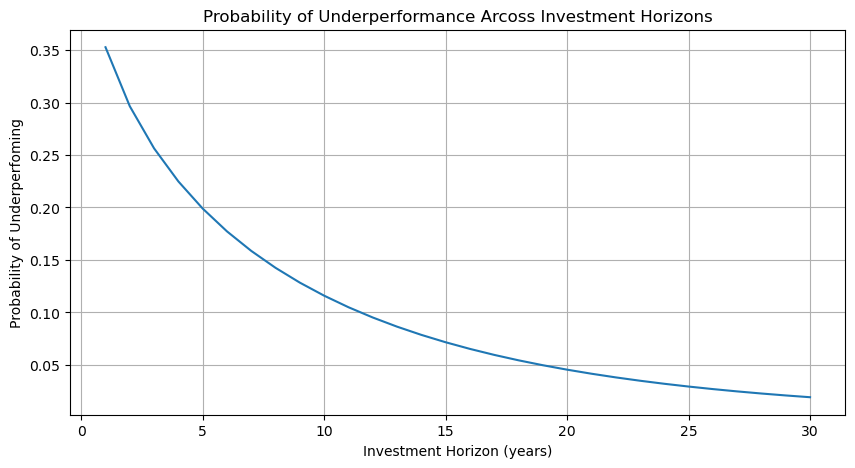

In [7]:
horizons = np.arange(1, 31)
prob = [norm.cdf(-np.sqrt(h) * mu_ex / vol_ex) for h in horizons]

plt.figure(figsize=(10,5))
plt.plot(horizons, prob)
plt.title('Probability of Underperformance Arcoss Investment Horizons')
plt.xlabel('Investment Horizon (years)')
plt.ylabel('Probability of Underperfoming')
plt.grid()
plt.show()

### 3 Full Sample Analysis
Use the sample 1965-2024 to reconsider the 30-year probability. As of the end of 2024, calculate the probability of the stock return underperforming the risk-free rate over the next 30 years. That is, $R_{mkt,t,t+h}$ underperforming $R_{f,t,t+h}$ for $0 < h \le 30$.

h = 30 (1965-2024 sample): 0.019248146171370953


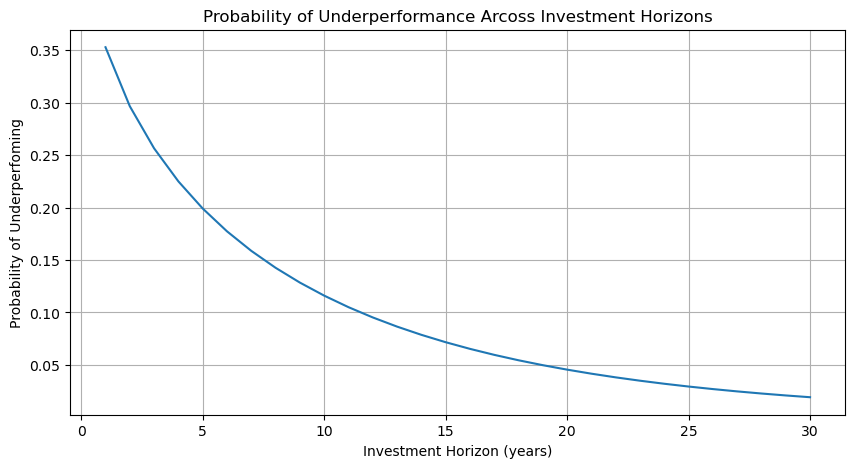

In [8]:
sub = ret[(ret['date'].dt.year >= 1965) & (ret['date'].dt.year <= 2024)]
mu_65_24 = sub['log_r_ex'].mean() * 12
vol_65_24 = sub['log_r_ex'].std() * np.sqrt(12)
print(f'h = 30 (1965-2024 sample): {norm.cdf(-np.sqrt(30) * mu_65_24 / vol_65_24)}')

prob_65_24 = [norm.cdf(-np.sqrt(h) * mu_65_24 / vol_65_24) for h in horizons]
plt.figure(figsize=(10,5))
plt.plot(horizons, prob_65_24)
plt.title('Probability of Underperformance Arcoss Investment Horizons')
plt.xlabel('Investment Horizon (years)')
plt.ylabel('Probability of Underperfoming')
plt.grid()
plt.show()

### 4 Historical Performance Analysis
Let’s consider how things turned out relative to Barnstable’s 1999 expectations.

What was the probability (based on the 1999 estimate of $\mu$) that the 25-year market return, $R_{mkt,t,t+25}$, would be smaller than that realized in 2000-2024? Note that we are asking about the market return, not the excess market return. Continue using the 1965-1999 sample standard deviation for $\sigma$.

In [9]:
mu = summ_piv[('Mean', '1965-1999')].loc['log_r_mkt']
vol = summ_piv[('Vol', '1965-1999')].loc['log_r_mkt']
h_00_24 = ret[(ret['date'].dt.year >= 2000) & (ret['date'].dt.year <= 2024)]
sample_avg_00_24 = h_00_24['log_r_ex'].mean() * 12

print(f"Prob(25-yr mkt returns < realized mkt returns '00-'24): {norm.cdf(-np.sqrt(25) * (mu - sample_avg_00_24) / vol)}")

Prob(25-yr mkt returns < realized mkt returns '00-'24): 0.02342722809202409


# Exercise - VaR

In [10]:
spx = pd.read_excel('spx_returns_weekly.xlsx', sheet_name='s&amp;p500 rets')
ticks = spx[['AAPL', 'META', 'NVDA', 'TSLA']]

### 1 Diversification
#### 1.1 
Using the full sample, calculate for each series the (unconditional)

volatility

empirical VaR (.05)

empirical CVaR (.05)

Recall that by empirical we refer to the direct quantile estimation. (For example, using .quantile() in pandas).

In [11]:
rows = []
for tick in ticks.columns:
    var = ticks[tick].quantile(.05)
    cvar = ticks[tick][ticks[tick] <= var].mean()
    rows.append({'tick': tick, 'Vol': ticks[tick].std() * np.sqrt(52), 'VaR(95%)': var, 'CVaR(95%)': cvar})
    
summ = pd.DataFrame(rows).set_index('tick')
summ

,Vol,VaR(95%),CVaR(95%)
tick,,,
AAPL,0.276629,-0.056366,-0.083125
META,0.351336,-0.070012,-0.103196
NVDA,0.463283,-0.086853,-0.116455
TSLA,0.586431,-0.117397,-0.147814


#### 1.2 
Form an equally-weighted portfolio of the investments.

Calculate the statistics of 1.1 for this portfolio, and compare the results to the individual return statistics. What do you find? What is driving this result?

In [12]:
port = ticks.mean(axis=1)
summ.loc['Portfolio'] = [port.std() * np.sqrt(52), port.quantile(.05), port[port <= port.quantile(.05)].mean()]
summ

,Vol,VaR(95%),CVaR(95%)
tick,,,
AAPL,0.276629,-0.056366,-0.083125
META,0.351336,-0.070012,-0.103196
NVDA,0.463283,-0.086853,-0.116455
TSLA,0.586431,-0.117397,-0.147814
Portfolio,0.315543,-0.061950,-0.084992


The volatility for the equally weighted portfolio is lower than the average volatility of the four components. Further, the 95% VaR is low relative to the VaR for each individual stock, and the CVaR is roughly the same ads the lowest CVaR for the stocks (AAPL) at $-0.085$. This result seems to reflect the power of diversification in risk management—reducing volatility and yielding a better VaR and CVaR than we might naively expect.

#### 1.3 
Re-calculate 1.2, but this time drop your most volatile asset, and replace the portion it was getting with 0. (You could imagine we’re replacing the most volatile asset with a negligibly small risk-free rate.)

In comparing the answer here to 1.2, how much risk is your most volatile asset adding to the portfolio? Is this in line with the amount of risk we measured in the stand-alone risk-assessment of 1.1?

In [13]:
# Most volatile asset is Tesla
new_port = (ticks.sum(axis=1) - ticks['TSLA']) / 4
summ.loc['Portfolio (No TSLA)'] = [new_port.std() * np.sqrt(52), new_port.quantile(.05), new_port[new_port <= new_port.quantile(.05)].mean()]
summ

,Vol,VaR(95%),CVaR(95%)
tick,,,
AAPL,0.276629,-0.056366,-0.083125
META,0.351336,-0.070012,-0.103196
NVDA,0.463283,-0.086853,-0.116455
TSLA,0.586431,-0.117397,-0.147814
Portfolio,0.315543,-0.061950,-0.084992
Portfolio (No TSLA),0.218365,-0.042463,-0.060531


When we drop TSLA, we see that the volatility for the new portfolio is now lower than the old portfolio and any of the individual stocks. In 1.1, we saw that TSLA's volatility was $0.59$. As we saw in 1.2, diversification helped in reducing vol, so intuitively, we don't see that TSLA adds vol of $0.59$ to the portfolio. However, when we look at TSLA's vol as a portion of the sum of the four volatilities for the individual stocks, it is relatively close to $\frac{1}{3}$: $\frac{0.59}{0.28 + 0.35 + 0.46 + 0.59} = \frac{0.59}{1.68}$. When TSLA is removed from the portfolio, about $\frac{1}{3}$ of the volatility ($\frac{0.1}{0.32}$) goes away. In other words, it appears that our most volatile asset (TSLA) is adding roughly $\frac{1}{3}$ of the volatility to the portfolio, which is in line with the stand-alone risk-assesment of 1.1.

### 2. Dynamic Measures
#### 2.1
Let’s measure the conditional statistics of the equally-weighted portfolio of 1.2, as of the end of the sample.

##### Volatility
For each security, calculate the rolling volatility series, $\sigma_t$, with a window of $m = 26$.

The value at $\sigma_t$ in the notes denotes the estimate using data through time $t - 1$, and thus (potentially) predicting the volatility at $\sigma_t$.

##### Mean
Suppose we can approximate that the daily mean return is zero.

##### VaR
Calculate the normal VaR and normal CVaR for $q = .05$ and $\tau = 1$ as of the end of the sample. Use the approximation, $\mathbf{z}_{.05} = -1.65$.

##### Conclude and Compare
Report
- volatility (annualized).
- normal VaR (.05)
- normal CVaR (.05)

How do these compare to the answers in 1.2?

In [14]:
rows = []
rolling_vols = pd.DataFrame(index=ticks.index)
rolling_vars = pd.DataFrame(index=ticks.index)
rolling_cvars = pd.DataFrame(index=ticks.index)

for tick in ticks.columns:
    rolling_vol = ticks[tick].rolling(window=26).std().shift(1)
    var_norm = -1.65 * rolling_vol
    cvar_norm = -rolling_vol * norm.pdf(-1.65) / 0.05

    rows.append({
        'tick': tick,
        'Vol (annualized) at End of Period': rolling_vol.iloc[-1] * np.sqrt(52),
        'Normal VaR(95%) at End of Period': var_norm.iloc[-1],
        'Normal CVaR(95%) at End of Period': cvar_norm.iloc[-1]
    })

    rolling_vols[tick] = rolling_vol
    rolling_vars[tick] = var_norm
    rolling_cvars[tick] = cvar_norm

summ = pd.DataFrame(rows).set_index('tick')
summ

,Vol (annualized) at End of Period,Normal VaR(95%) at End of Period,Normal CVaR(95%) at End of Period
tick,,,
AAPL,0.357871,-0.081886,-0.101504
META,0.416450,-0.095290,-0.118119
NVDA,0.596552,-0.136499,-0.169201
TSLA,0.612053,-0.140046,-0.173598


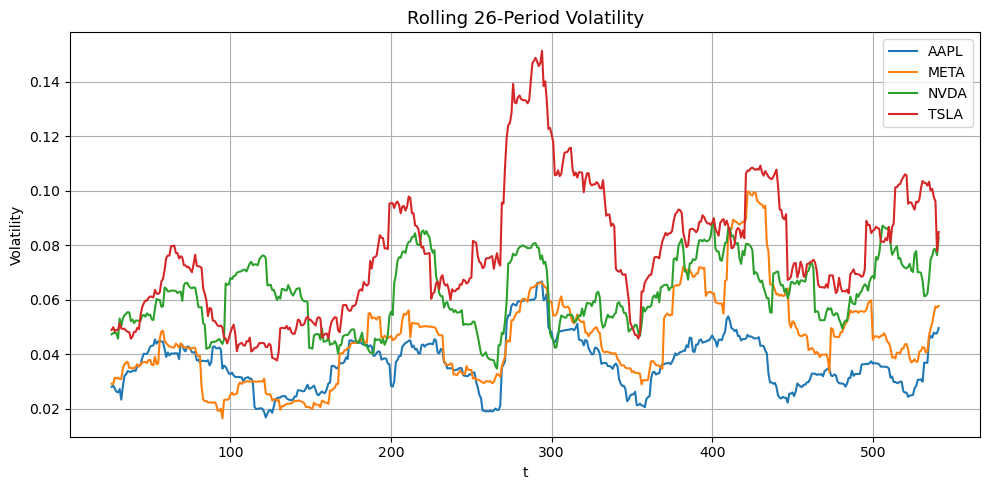

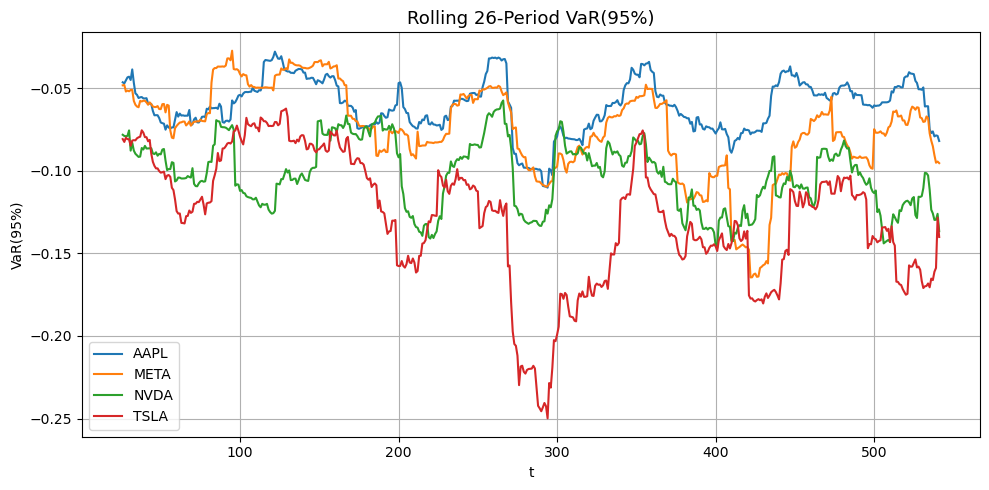

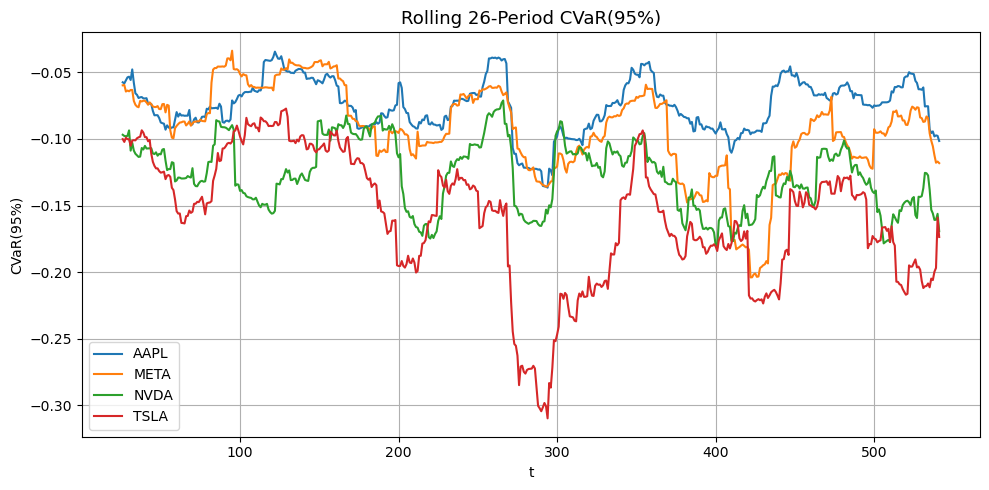

In [15]:
plt.figure(figsize=(10, 5))
rolling_vols.plot(ax=plt.gca())
plt.title('Rolling 26-Period Volatility', fontsize=13)
plt.ylabel('Volatility')
plt.xlabel('t')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
rolling_vars.plot(ax=plt.gca())
plt.title('Rolling 26-Period VaR(95%)', fontsize=13)
plt.ylabel('VaR(95%)')
plt.xlabel('t')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
rolling_cvars.plot(ax=plt.gca())
plt.title('Rolling 26-Period CVaR(95%)', fontsize=13)
plt.ylabel('CVaR(95%)')
plt.xlabel('t')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

From the plots, we can see that the end-of-period estimates for VaR and CVaR were not significant outliers, so we'll use them as a rough proxy for the overall measurements of rolling VaR and CVaR (i.e., to compare against the empirical measurement). Compared to 1.2, we see that VaR and CVaR are higher across the board (using measurements from end of period). Intuitively, this is most likely because mean returns over this period were slightly above $0$. Therefore, when we estimate VaR with the assumption of mean-zero returns, we underestimated the overall distribution of returns, leading to a more extreme estimation of VaR (and consequently, CVaR).

Finally, it's worth noting that the massive large spikes in volatility (e.g., TSLA near $t = 300$) correlate with spikes in VaR and CVaR, which is what we would expect given that volatility is typically asymmetric (negative returns tend to be correlated with higher vol than positive returns of similar magnitude).

#### 2.2
Backtest the VaR using the hit test. Namely, check how many times the realized return at $t$ was smaller than the VaR return calculated using $\sigma_t$, (where again remember the notation in the notes uses $\sigma_t$ as a vol based on data through $t - 1$).

Report the percentage of “hits” using both the
- expanding volatility
- rolling volatility

In [16]:
hits = (ticks < rolling_vars).astype(int)

expanding_vol = ticks.expanding(min_periods=26).std()
expanding_var = -1.65 * expanding_vol
hits_exp = (ticks < expanding_var).astype(int)

pd.DataFrame({'Rolling Hit Rate': hits.sum() / hits.count(), 'Expanding Hit Rate': hits_exp.sum() / hits_exp.count()})

,Rolling Hit Rate,Expanding Hit Rate
AAPL,0.049815,0.042435
META,0.042435,0.046125
NVDA,0.042435,0.027675
TSLA,0.049815,0.062731
